In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import animation
from IPython.display import HTML

In [2]:
HIDDEN_MU = [49.3, 50, 86.2, 87.6, 108.1, 109.4, 139.1, 138, 155.9, 170.7]
HIDDEN_SIGMA = [1.88, 1.87, 3.24, 3.08, 4.91, 4.61, 6.97, 6.88,  6.32, 6.63] 
def get_data_a(n=1000, k=0):
  return np.random.randn(n) * HIDDEN_SIGMA[k] + HIDDEN_MU[k]

HIDDEN_PI = np.random.dirichlet([1, 1, 1])
HIDDEN_PI = np.array([.514, .486, .513, .487, .512, .488, .514, .486, .55, .45])
HIDDEN_PI /= np.sum(HIDDEN_PI) 
def get_responsibilities(p, n=10000):
  n_per_cluster = np.random.multinomial(n, p)
  r = [[k] * n_k for k, n_k in enumerate(n_per_cluster)]
  r = np.concatenate(r)
  np.random.shuffle(r)
  return r

R = get_responsibilities(HIDDEN_PI)
def get_data_b():
  y = np.random.randn(len(R))
  for t, k in enumerate(R):
    y[t] *= HIDDEN_SIGMA[k]
    y[t] += HIDDEN_MU[k]
  return y

def get_data_c(n_x=6):
  return np.eye(n_x * 3).reshape((-1, n_x, 3))

In [3]:
plt.rcParams['figure.figsize'] = [12, 2.5]
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.3)

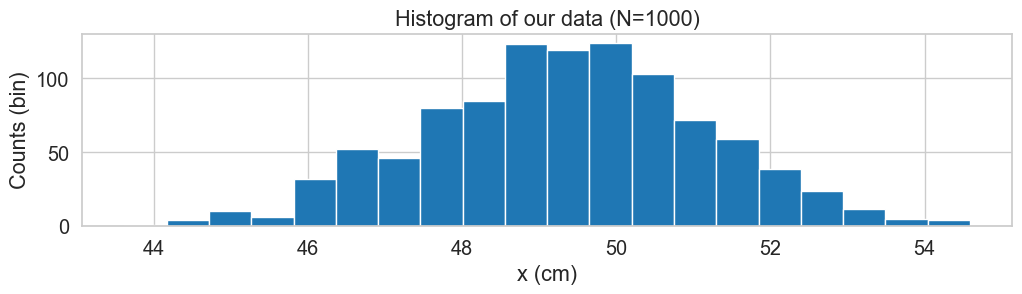

In [4]:
x_a = get_data_a()
counts, bins, _ = plt.hist(x_a, bins=20)
plt.title(f'Histogram of our data (N={len(x_a)})')
plt.ylabel('Counts (bin)')
plt.xlabel('x (cm)');

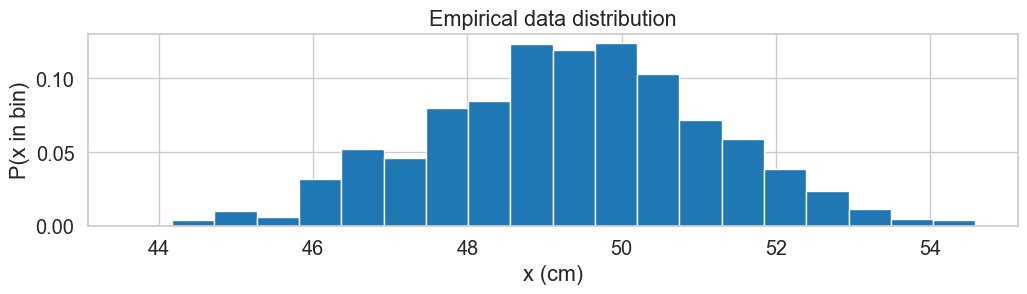

In [5]:
p_bins = counts / np.sum(counts)

dx = bins[1] - bins[0]
bin_centers = bins[:-1] + dx / 2
plt.bar(bin_centers, p_bins, dx)
plt.title('Empirical data distribution')
plt.ylabel('P(x in bin)')
plt.xlabel('x (cm)');

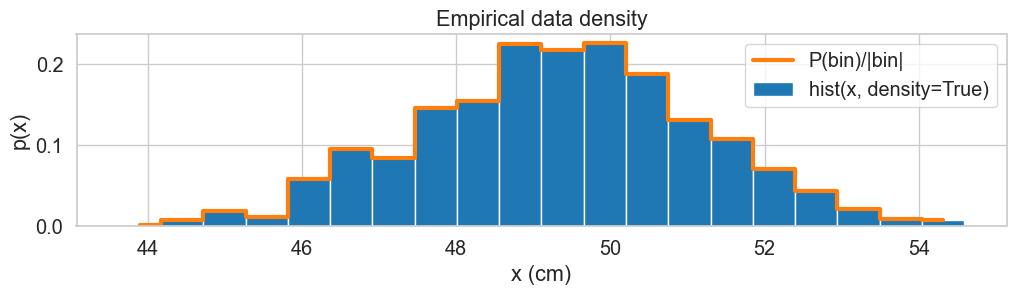

In [6]:
p_bins_density = p_bins / dx
plt.step(bin_centers, p_bins_density, 
         where='mid', c='tab:orange', lw=3, label=r'P(bin)/|bin|')
plt.hist(x_a, bins=20, density=True, 
         label='hist(x, density=True)')

plt.title('Empirical data density')
plt.ylabel('p(x)')
plt.xlabel('x (cm)');
plt.legend()

In [7]:
def bell_curve(x, mu, sigma_2):
    y = np.exp(- (x - mu)**2 / 2 / sigma_2)
    y /= np.sqrt(2 * np.pi * sigma_2)
    return y

In [8]:
x_mean, x_var, n_x = np.mean(x_a), np.var(x_a), len(x_a)
print('Mean of our data: {:.2g}cm, variance: {:.2g}cm^2 (N={})'.format(x_mean, x_var, n_x))

Mean of our data: 49cm, variance: 3.3cm^2 (N=1000)


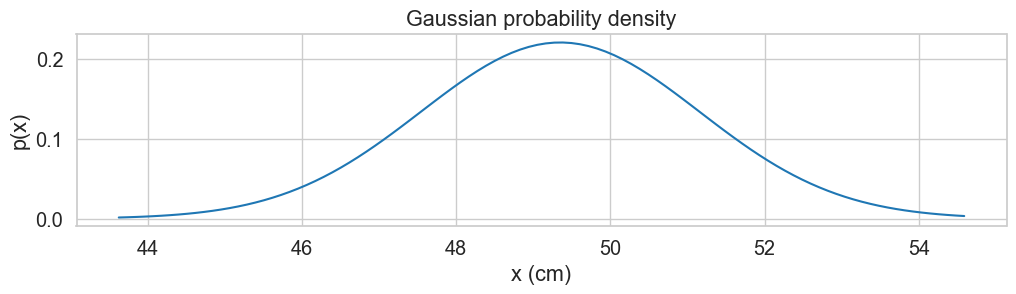

In [9]:
x_ = np.linspace(np.min(x_a), np.max(x_a), 100)
p_x = bell_curve(x_, x_mean, x_var)
plt.plot(x_, p_x)
plt.title(r'Gaussian probability density')
plt.ylabel('p(x)')
plt.xlabel('x (cm)');

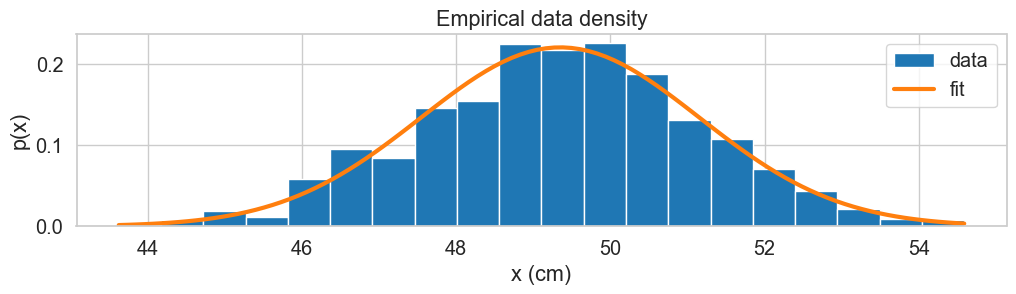

In [10]:
plt.hist(x_a, bins=20, density=True, label='data')
plt.plot(x_, p_x, lw=3, label='fit')
plt.title('Empirical data density')
plt.ylabel('p(x)')
plt.xlabel('x (cm)');
plt.legend();

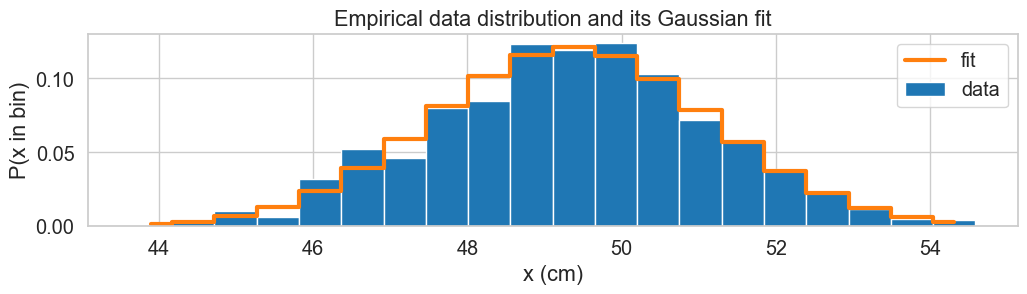

In [11]:
plt.bar(bin_centers, p_bins, dx, label='data')

p_gauss_bins = dx * bell_curve(bin_centers, x_mean, x_var)
plt.step(bin_centers, p_gauss_bins, where='mid', c='tab:orange', lw=3, 
         label='fit')

plt.title('Empirical data distribution and its Gaussian fit')
plt.ylabel('P(x in bin)')
plt.xlabel('x (cm)');
plt.legend();

In [12]:
def log_loss_gaussian(x_, mu, sigma_2):
  log_p = ((x_ - mu)**2 / sigma_2  + np.log(sigma_2) + np.log(2 * np.pi)) / 2
  return np.sum(log_p)

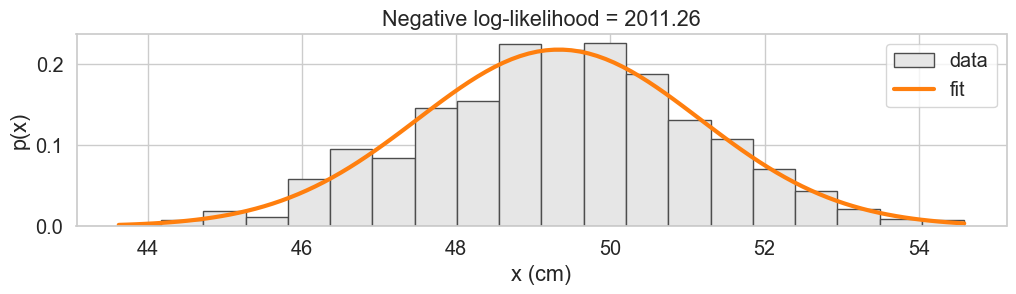

In [13]:
mu = 49.33 # {min:40, max:60}
sigma_2 = 3.35 # {min:0, max:100}

plt.hist(x_a, bins=20, density=True, label='data',
         facecolor='.9', edgecolor='.3')
plt.plot(x_, bell_curve(x_, mu, sigma_2), lw=3, label='fit')
plt.title('Negative log-likelihood = {:.2f}'.format(log_loss_gaussian(x_a, mu, sigma_2)))
plt.ylabel('p(x)')
plt.xlabel('x (cm)');
plt.legend();

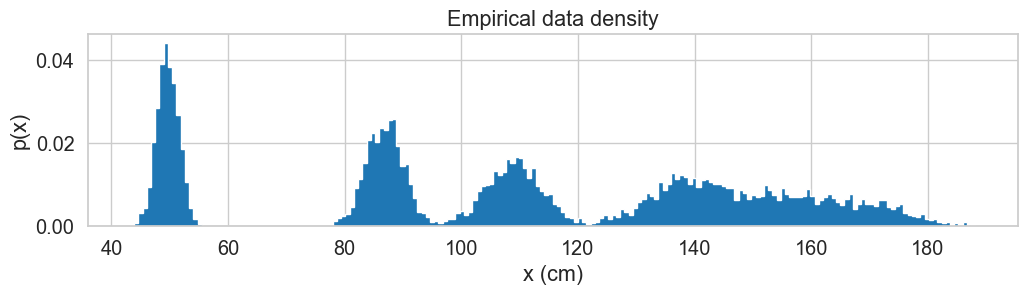

In [14]:
x_b = get_data_b()
plt.hist(x_b, bins=200, density=True, histtype='stepfilled');
plt.title('Empirical data density')
plt.ylabel('p(x)')
plt.xlabel('x (cm)');

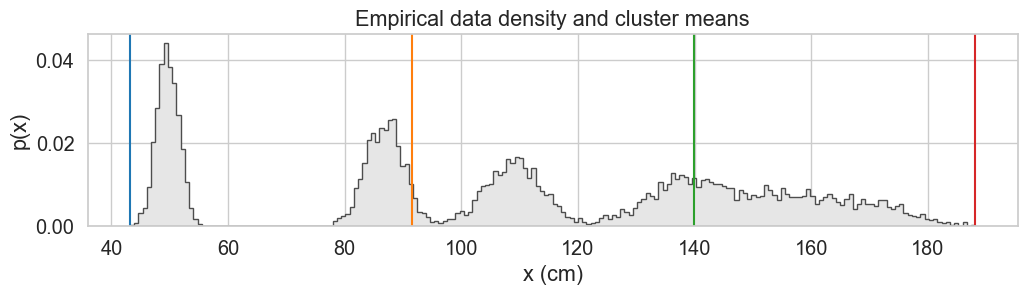

In [15]:
n_c = 4
n_x = len(x_b)
mu_b = np.linspace(min(x_b), max(x_b), n_c)

plt.hist(x_b, bins=200, density=True, histtype='stepfilled', 
         facecolor='.9', edgecolor='.3')
mu_colors = sns.color_palette(n_colors=n_c)
for k_c, mu_k in enumerate(mu_b):
  plt.axvline(mu_k, c=mu_colors[k_c])

plt.title('Empirical data density and cluster means')
plt.ylabel('p(x)')
plt.xlabel('x (cm)');

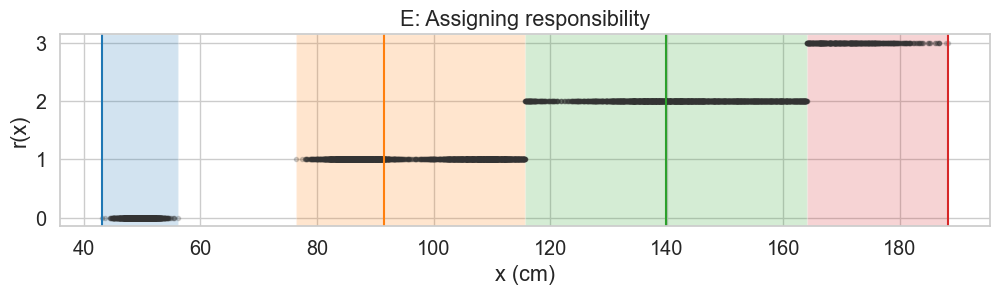

In [16]:
r = np.zeros(n_x, dtype='int16')
for k, x_k in enumerate(x_b):
  r[k] = np.argmin(np.abs(x_k - mu_b))

plt.plot(x_b, r, '.', alpha=.2, color='.2')
for k_c, mu_k in enumerate(mu_b):
  x_b_c = x_b[r == k_c]
  plt.axvspan(min(x_b_c), max(x_b_c), 
              facecolor=mu_colors[k_c], alpha=0.2)
  plt.axvline(mu_k, c=mu_colors[k_c])
  
plt.title('E: Assigning responsibility')
plt.ylabel('r(x)')
plt.xlabel('x (cm)');

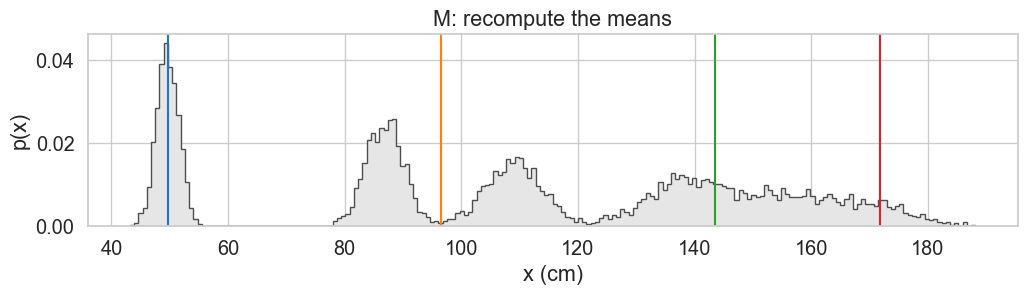

In [17]:
for k_c in range(n_c):
  mu_b[k_c] = np.mean(x_b[r == k_c])

plt.hist(x_b, bins=200, density=True, histtype='stepfilled', 
         facecolor='.9', edgecolor='.3')
for k_c, mu_k in enumerate(mu_b):
  plt.axvline(mu_k, c=mu_colors[k_c])
plt.title('M: recompute the means')
plt.ylabel('p(x)')
plt.xlabel('x (cm)');

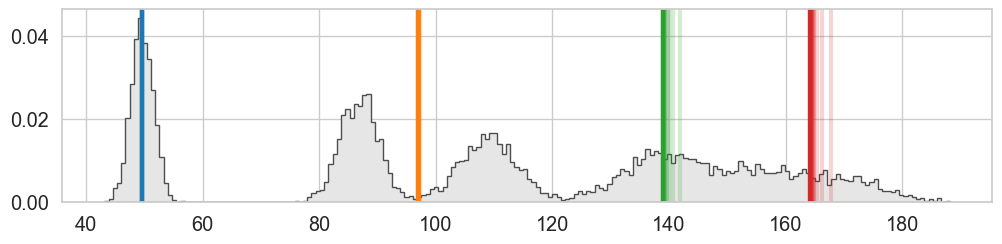

In [19]:
def e_step(x, mu):
  r = [np.nanargmin(np.abs(x_k - mu))
      for k, x_k in enumerate(x)]      
  return np.array(r)

def m_step(x, r, cluster_ids):
  mu_c = np.ones_like(cluster_ids) * np.nan
  for k_c in cluster_ids:
    x_c = x[r == k_c]
    if np.any(x_c):
      mu_c[k_c] = np.mean(x_c) 
  return mu_c

n_steps = 10
plt.hist(x_b, bins=200, density=True, histtype='stepfilled', 
         facecolor='.9', edgecolor='.3')
           
for t in range(n_steps):
  r = e_step(x_b, mu_b)
  mu_b = m_step(x_b, r, range(n_c))
  for k_c, mu_k in enumerate(mu_b):
    plt.axvline(mu_k, c=mu_colors[k_c], alpha=max(.2, t/n_steps), lw=3)

In [22]:
def k_means(x, n_clusters, n_steps=10):
  n_steps += 1 # Need one for the initial values.
  mu_over_time = np.zeros((n_steps, n_clusters))
  rlim_over_time = np.zeros((n_steps, n_clusters, 2)) * np.nan
  mu_over_time[0] = np.random.randn(n_clusters) * np.std(x) + np.mean(x)
  for t in range(1, n_steps):
    r = e_step(x, mu_over_time[t - 1])
    for k_c in range(n_clusters):
      x_b_k = x_b[r == k_c]    
      if len(x_b_k):
        rlim_over_time[t, k_c] = [min(x_b_k), max(x_b_k)]  
    mu_over_time[t] = m_step(x, r, range(n_clusters))
  return mu_over_time, rlim_over_time

def animate_kmeans(x, mu_over_time, rlim_over_time):
  n_steps, n_clusters = np.shape(mu_over_time)
  colors = sns.color_palette(n_colors=n_clusters)

  fig, ax = plt.subplots()
  # Initialise graphics:
  areas = [plt.axvspan(np.nan, np.nan, facecolor=colors[k_c], alpha=0.2)
          for k_c in range(n_clusters)]
  plt.hist(x, bins=200, density=True, histtype='stepfilled', 
           facecolor='.9', edgecolor='.3')
  lines = [plt.axvline(0, c=colors[k_c])
          for k_c in range(n_clusters)]

  def animate_(frame_no): 
    frame_type = frame_no % 2
    t = frame_no // 2  
    for k_c, mu_k in enumerate(mu_over_time[t]):
      if frame_type or frame_no == 0:
        lines[k_c].set_data([mu_k, [0, 1]])
      else:
        xy = areas[k_c].get_xy()   
        xy[:, 0] = rlim_over_time[t][k_c][0]
        xy[2:-1, 0] = rlim_over_time[t][k_c][1]
        areas[k_c].set_xy(xy)
    if t == 0:
      s_title = 'Initialise clusters' 
    else:
      s_title = '{}. {}-Step'.format(t, ['E', 'M'][frame_type])
    ax.set_title(s_title)     

  my_anim = animation.FuncAnimation(fig, animate_, frames=2 * n_steps, 
                                interval=600)
  plt.close()
  return HTML(my_anim.to_jshtml())

In [23]:
params_over_time = k_means(x_b, n_clusters=4)
animate_kmeans(x_b, *params_over_time)

C:\Users\mustafa\AppData\Local\Temp\ipykernel_13868\1190455817.py:33: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lines[k_c].set_data([mu_k, [0, 1]])
